In [ ]:
import sys
import os
import glob
from importlib import reload
from copy import deepcopy
from typing import List

import numpy as np
import yaml
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
pd.set_option("max_colwidth", None)

### Downloading the data from the expriments

In [ ]:
%%bash 

mkdir -p ../data/final_experiment_results
gcloud config set account $COMMENTS_ON_SEMI_PARAMETRIC_SAMPLING_EMAIL
gsutil -m cp -r gs://$COMMENTS_ON_SEMI_PARAMETRIC_SAMPLING_BUCKET/Tfinal_experiment_* ../data/final_experiment_results/

### Reading the data

In [3]:
path = '../data/final_experiment_results'

In [4]:
results = []
for p in tqdm(sorted(glob.glob(os.path.join(path, "*")))): 
    with open(os.path.join(p, 'environment_kwargs'), 'r') as f:
        environment_dict = yaml.safe_load(f)
    with open(os.path.join(p, 'regrets'), 'r') as f:
        regrets = yaml.safe_load(f)
    model_names = list(regrets.keys())
    for model_name in model_names:
        all_dict = deepcopy(environment_dict)
        with open(os.path.join(p, f'{model_name}_kwargs'), 'r') as f:
            model_dict = yaml.safe_load(f)
        total_regret = sum(regrets[model_name])
        all_dict.update(model_dict)
        all_dict['total_regret'] = total_regret
        all_dict['path'] = p
        all_dict['regret'] = regrets[model_name]
        all_dict['model_name'] = model_name
        results.append(all_dict)

100%|██████████| 12/12 [09:07<00:00, 45.61s/it]


### Processing the data

In [5]:
df = pd.DataFrame.from_records(results)

In [6]:
df.model_name.value_counts()

LinearSemiParametricSampling    12
GaussianPriorsSampling          12
LinearGaussianSampling          12
BetaPriorsSampling               6
Name: model_name, dtype: int64

### Calculation of cumulative regret

In [7]:
def get_cumulative_regret(regret: List[float]) -> np.array:
    regret_np = np.asarray(regret)
    return np.cumsum(regret_np)

In [8]:
get_cumulative_regret([0, 13, 2])

array([ 0, 13, 15])

In [9]:
df['cumulative_regret'] = df.regret.apply(get_cumulative_regret)

In [10]:
df.sort_values(by=['reward_distribution', 'a', 'model_name', 'sigma_1', 'sigma_2', 'sigma_3', 'v', 'seed'], inplace=True)

In [11]:
def parameters(row: pd.core.series.Series) -> str:
    """
    Process parameters into one string so it's easy to display and analyse it
    """
    if row['v'] > 0:
        return 'v = {}'.format(row['v'])
    if row['sigma_1'] > 0:
        return '$\sigma_1$ = {}, $\sigma_2$ = {}, $\sigma_3$ = {}'.format(row['sigma_1'], row['sigma_2'], row['sigma_3'])
    else: 
        return ''

In [12]:
df['parameters'] = df.apply(lambda row: parameters(row), axis=1)

In [13]:
df_grouped_for_all_seeds = df.groupby(['reward_distribution',  'a', 'model_name', 'parameters']).total_regret.agg([np.mean, np.max, np.min]).reset_index().rename(columns={'mean': 'reg_mean',
                                                                                                                                                'amax': 'reg_max', 
                                                                                                                                                'amin': 'reg_min'})
df_grouped_for_all_seeds['hp_rank'] =  df_grouped_for_all_seeds.groupby(['reward_distribution',  'a',  'model_name']).reg_mean.transform(lambda x: x.rank(method='dense'))
df_grouped_for_all_seeds.sort_values(by=['reward_distribution',  'a',  'model_name', 'hp_rank'], inplace=True)

### Table with the results

In [14]:
df_grouped_for_all_seeds

,reward_distribution,a,model_name,parameters,reg_mean,reg_max,reg_min,hp_rank
0,binomial,0.5,BetaPriorsSampling,,8485.567719,10979.346765,5918.236027,1.0
1,binomial,0.5,GaussianPriorsSampling,,33996.477382,35459.349794,31228.519594,1.0
2,binomial,0.5,LinearGaussianSampling,v = 1.0,5850.107473,10219.050364,1392.792874,1.0
3,binomial,0.5,LinearSemiParametricSampling,"$\sigma_1$ = 0.1, $\sigma_2$ = 0.1, $\sigma_3$ = 0.1",11887.841665,28273.943636,146.797519,1.0
4,binomial,1.0,BetaPriorsSampling,,7355.232504,8359.397451,6493.954159,1.0
5,binomial,1.0,GaussianPriorsSampling,,29788.953966,32396.543469,27389.006134,1.0
6,binomial,1.0,LinearGaussianSampling,v = 1.0,537.308866,818.742203,241.478109,1.0
7,binomial,1.0,LinearSemiParametricSampling,"$\sigma_1$ = 0.1, $\sigma_2$ = 0.1, $\sigma_3$ = 1.0",143.273243,224.208509,80.402564,1.0
8,normal,0.5,GaussianPriorsSampling,,34950.217525,38854.898440,30551.222317,1.0
9,normal,0.5,LinearGaussianSampling,v = 1.0,29757.076802,31937.356460,26442.405550,1.0


### Preparation of table for the paper

In [15]:
df_to_table = df_grouped_for_all_seeds.copy()
df_to_table.rename(columns={'reward_distribution': 'Reward distribution', 'a': 'a', 
                             'model_name': 'Model', 'parameters':'Hyperparametes',
                             'reg_mean': 'Average cumulative regret', 'reg_max': 'Max', 
                             'reg_min': 'Min', 'hp_rank': 'hp_rank'}, inplace=True)

Renaming the models:

In [16]:
model_shorter = {'BetaPriorsSampling': 'TS-Beta',
 'GaussianPriorsSampling': 'TS-Gau',
 'LinearGaussianSampling': 'TS-Lin',
 'LinearSemiParametricSampling': 'LSPS'}
for m, s in model_shorter.items():
    df_to_table.loc[df_to_table['Model']==m, 'Model'] = s

In [17]:
print(df_to_table[['Reward distribution', 'a', 'Model', 'Average cumulative regret', 'Min', 'Max', 'Hyperparametes']].to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrlrrrl}
\toprule
Reward distribution &    a &    Model &  Average cumulative regret &      Min &      Max &                                        Hyperparametes \\
\midrule
           binomial & 0.50 &  TS-Beta &                    8485.57 &  5918.24 & 10979.35 &                                                       \\
           binomial & 0.50 &   TS-Gau &                   33996.48 & 31228.52 & 35459.35 &                                                       \\
           binomial & 0.50 &   TS-Lin &                    5850.11 &  1392.79 & 10219.05 &                                               v = 1.0 \\
           binomial & 0.50 &     LSPS &                   11887.84 &   146.80 & 28273.94 &  \$\textbackslash sigma\_1\$ = 0.1, \$\textbackslash sigma\_2\$ = 0.1, \$\textbackslash sigma\_3\$ = 0.1 \\
           binomial & 1.00 &  TS-Beta &                    7355.23 &  6493.95 &  8359.40 &                                                       \\
           binomia

### Plots for the paper

In [18]:
dfs_for_plot = []
for i, row in tqdm(df.iterrows()):
    df_tmp = pd.DataFrame({'cumulative_regret': row.cumulative_regret, 'step': list(range(len(row.cumulative_regret))), 
                           'model_name': row['model_name'], 'reward_distribution': row['reward_distribution'],
                           'parameters': row['parameters'], 'seed': row['seed'], 'a': row['a']})
    dfs_for_plot.append(df_tmp)

42it [00:02, 16.78it/s]


In [19]:
df_for_plot = pd.concat(dfs_for_plot)
df_for_plot.head()

,cumulative_regret,step,model_name,reward_distribution,parameters,seed,a
0,0.202205,0,BetaPriorsSampling,binomial,,4,0.5
1,0.540653,1,BetaPriorsSampling,binomial,,4,0.5
2,0.597202,2,BetaPriorsSampling,binomial,,4,0.5
3,1.086173,3,BetaPriorsSampling,binomial,,4,0.5
4,1.436495,4,BetaPriorsSampling,binomial,,4,0.5


In [20]:
agg_columns = [c for c in df_for_plot.columns if c not in ('seed', 'cumulative_regret')]
df_for_plot_agg = df_for_plot.groupby(agg_columns).cumulative_regret.agg([np.mean, np.max, np.min]).reset_index()
df_for_plot_agg.head()

,step,model_name,reward_distribution,parameters,a,mean,amax,amin
0,0,BetaPriorsSampling,binomial,,0.5,0.425834,0.612039,0.202205
1,0,BetaPriorsSampling,binomial,,1.0,0.458444,0.510850,0.394442
2,0,GaussianPriorsSampling,binomial,,0.5,0.460697,0.639683,0.316563
3,0,GaussianPriorsSampling,binomial,,1.0,0.342272,0.684357,0.055597
4,0,GaussianPriorsSampling,normal,,0.5,0.460697,0.639683,0.316563


binomial
0.5
binomial
1.0


No handles with labels found to put in legend.


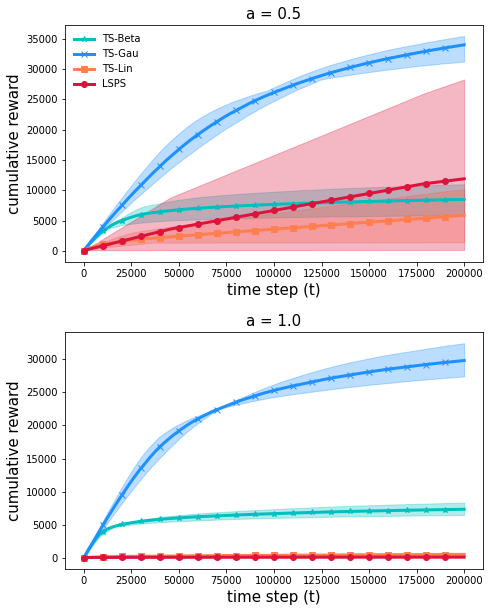

normal
0.5
normal
1.0


No handles with labels found to put in legend.


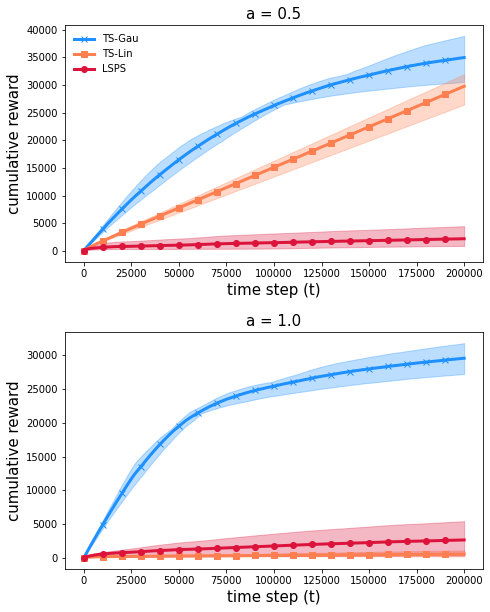

In [21]:
steps = len(df.cumulative_regret[0])
models = list(df.model_name.unique())
distributions = list(df.reward_distribution.unique())
a_values = list(df.a.unique())
x = np.arange(steps)

colors = {'BetaPriorsSampling': 'c',
 'GaussianPriorsSampling': 'dodgerblue',
 'LinearGaussianSampling': 'coral',
 'LinearSemiParametricSampling': 'crimson'}

labels = {'BetaPriorsSampling': 'TS-Beta',
 'GaussianPriorsSampling': 'TS-Gau',
 'LinearGaussianSampling': 'TS-Lin',
 'LinearSemiParametricSampling': 'LSPS'}

symbols = {'BetaPriorsSampling': "*",
 'GaussianPriorsSampling': "x",
 'LinearGaussianSampling': 's',
 'LinearSemiParametricSampling': "o"}

for i_d, dist in enumerate(distributions):
    fig, axs = plt.subplots(2, 1, figsize=[7.5, 10])
    for i_a, a in enumerate(a_values):
        print(dist)
        print(a)
        for m in models: # ["LinearSemiParametricSampling"]:#
            color = colors[m]
            df_m = df_for_plot_agg.query(f"model_name == '{m}' and reward_distribution == '{dist}' and a == {a}")
            params = list(df_m.parameters.unique())
            for i, p in enumerate(params):
                df_p = df_m[df_m.parameters == p].sort_values(by='step')
                linewidth = 3
                linestyle = symbols[m]
                y = df_p['mean'].values
                upper = df_p['amax'].values 
                lower = df_p['amin'].values
                
                
                if i_a == 0:
                    label=labels[m]
                else:
                    label = None
                axs[i_a].plot(x, y, label=label, color=color, linewidth=linewidth, marker=linestyle, markevery=10000)
                axs[i_a].fill_between(x, upper, lower, color=color, alpha=.3)
                axs[i_a].set_title(f"a = {a}", fontsize=15)

    for ax in fig.get_axes():
        ax.set_xlabel('time step (t)', fontsize=15)
        ax.set_ylabel('cumulative reward', fontsize=15)
        ax.legend(loc='upper left', frameon=False) 
    plt.subplots_adjust(hspace = 0.3, wspace=0.05 )
    plt.savefig(f'results_{dist}.png', bbox_inches='tight', pad_inches=0.05)
    plt.show()